In [48]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from ultralytics import YOLO
import os
import networkx as nx
from skimage.morphology import skeletonize
from skimage.util import img_as_ubyte

### Padding

In [ ]:
def resize_to_2_3_aspect_ratio(image):
    """
    Приводит изображение к формату 2:3, добавляя паддинг по бокам или сверху/снизу.
    :param image: Входное изображение (numpy array).
    :return: Изображение с соотношением сторон 2:3.
    """
    h, w = image.shape[:2]
    target_aspect_ratio = 5 / 6
    current_aspect_ratio = w / h

    if current_aspect_ratio < target_aspect_ratio:
        new_width = int(h * target_aspect_ratio)
        padding = (new_width - w) // 2
        padded_image = cv2.copyMakeBorder(image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    else:
        new_height = int(w / target_aspect_ratio)
        padding = (new_height - h) // 2
        padded_image = cv2.copyMakeBorder(image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return padded_image

In [11]:
folder_path = 'cropped_objects'

def process_images_in_folder(folder_path, output_dir='padding_objects'):

    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.JPG'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"Ошибка загрузки изображения: {image_path}")
            continue

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        resized_image = resize_to_2_3_aspect_ratio(image_rgb)

        output_path = os.path.join(output_dir, image_file)
        cv2.imwrite(output_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

In [12]:
process_images_in_folder(folder_path)

### Извлечение символов и нахождение строк

In [22]:
image_path = "padding_objects/01014428_1.JPG"
image = cv2.imread(image_path)

In [3]:
model = YOLO('best_ce.pt')

In [23]:
results = model.predict(image)

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]


0: 768x640 300 symbols, 341.8ms
Speed: 12.7ms preprocess, 341.8ms inference, 13.5ms postprocess per image at shape (1, 3, 768, 640)


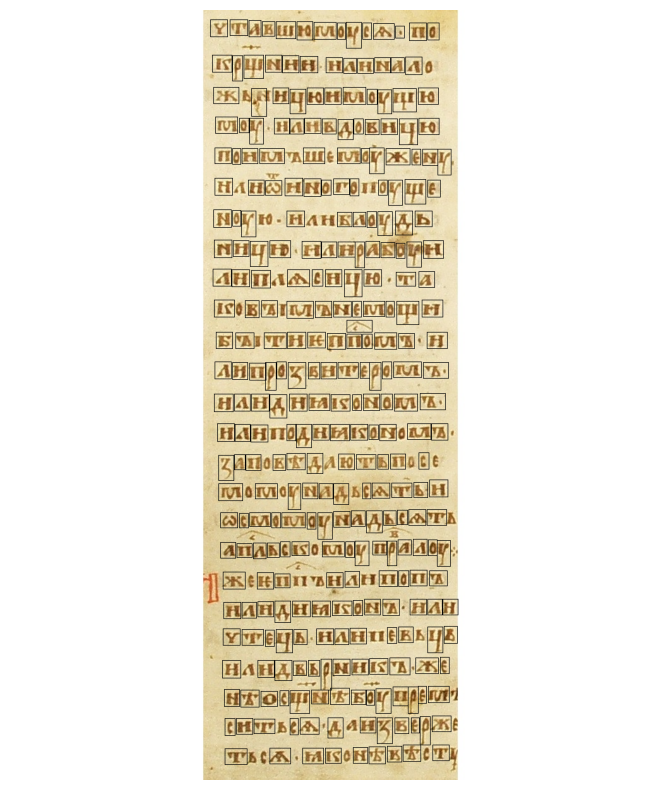

In [15]:
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]

        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

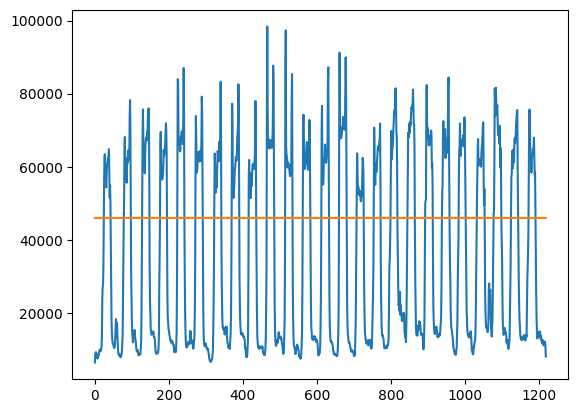

In [27]:
def get_peak_regions(hpp, divider=2):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    threshold_line = [threshold for i in range(len(hpp))]
    plt.figure(1)
    plt.plot(hpp)
    plt.plot(threshold_line)
    plt.show()
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

def get_walking_regions_between_lines(peaks):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks):
        cluster.append(value)
        if index < len(peaks)-1 and peaks[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []
        if index == len(peaks)-1:
            hpp_clusters.append(cluster)
            cluster = []
    return hpp_clusters

img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
sobel_img = np.sqrt(Gx * Gx + Gy * Gy)
hpp = np.sum(sobel_img, axis=1)
peaks = get_peak_regions(hpp)
peaks_index = np.array(peaks)[:,0].astype(int)
hpp_clusters = get_walking_regions_between_lines(peaks_index)

Линии между строками: [33, 88, 137, 185, 232, 281, 332, 380, 426, 474, 524, 572, 622, 670, 717, 763, 808, 854, 903, 948, 993, 1043, 1088, 1134, 1182]


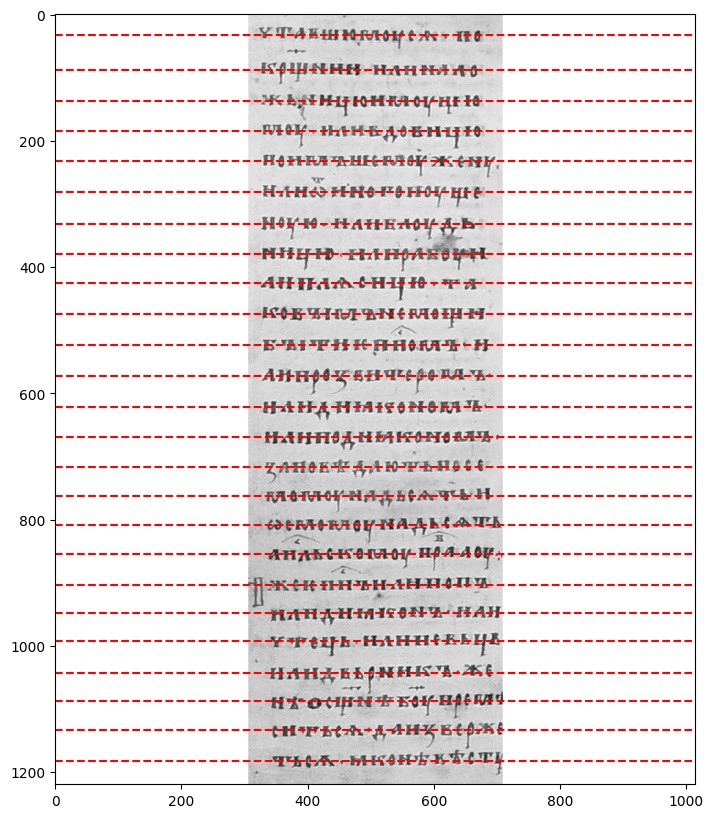

In [31]:
def get_line_positions(hpp_clusters):
    line_positions = []
    for i in range(len(hpp_clusters) - 1):
        lower_bound = hpp_clusters[i][-1]  # Последний индекс в текущем кластере (нижняя граница строки)
        upper_bound = hpp_clusters[i + 1][0]  # Первый индекс в следующем кластере (верхняя граница следующей строки)
        separator = (lower_bound + upper_bound) // 2  # Средняя точка между ними
        line_positions.append(separator)
    return line_positions

line_positions = get_line_positions(hpp_clusters)
print("Линии между строками:", line_positions)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
for y in line_positions:
    plt.axhline(y, color='red', linestyle='--')
plt.show()

In [5]:
def process_images_in_folder(folder_path, model, output_dir='letters'):

    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.JPG'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"Ошибка загрузки изображения: {image_path}")
            continue

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        results = model.predict(image_rgb)

        base_name = os.path.splitext(image_file)[0]

        for i, result in enumerate(results):
            boxes = result.boxes
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                class_id = int(box.cls[0])
                confidence = box.conf[0]

                cropped_object = image_rgb[y1:y2, x1:x2]

                output_path = os.path.join(output_dir, f'{base_name}_{j + 1}.JPG')
                cv2.imwrite(output_path, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))

                #print(f"Saved: {output_path}")

        print(f"Обработано изображение: {image_path}")

folder_path = 'padding_objects'

# Структурный анализ

In [7]:
def thresholding(image, inv=True):
    #image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if inv:
        ret,thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        ret,thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    return thresh

In [14]:
image_path = "letters/ex4.JPG"
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_RGB2GRAY)

### Скелетизация

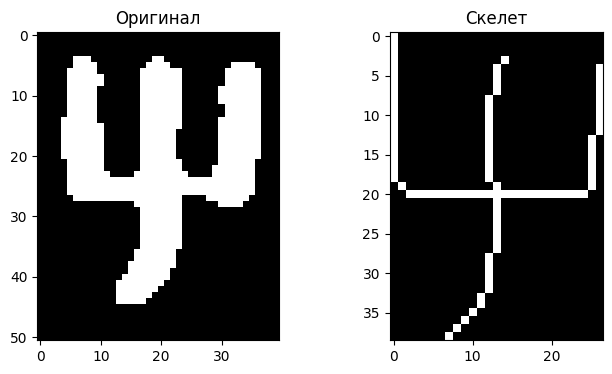

In [16]:
binary = thresholding(image)

# Скелетизация
skeleton = skeletonize(binary > 0)

rows = np.any(skeleton, axis=1)
cols = np.any(skeleton, axis=0)

cropped = skeleton[np.ix_(rows, cols)]

# Отображение результата
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(binary, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Скелет")
plt.imshow(cropped, cmap="gray")

plt.show()

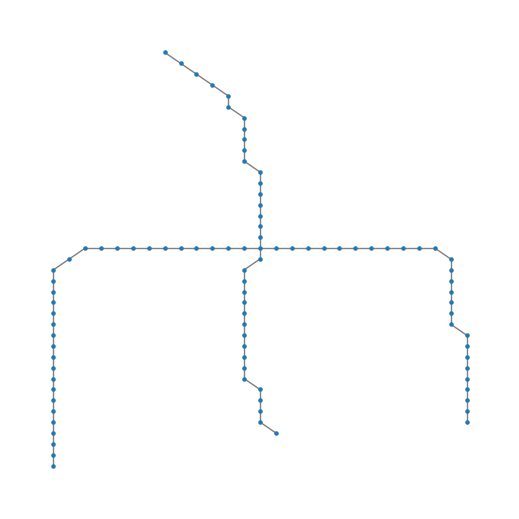

In [20]:
def get_skeleton_graph(image):
    
    binary = thresholding(image)
    #binary = thresholding(image, inv=False)
    
    skeleton = skeletonize(binary > 0)
    rows = np.any(skeleton, axis=1)
    cols = np.any(skeleton, axis=0)
    
    cropped = skeleton[np.ix_(rows, cols)]
    height, width = cropped.shape
    graph = nx.Graph()
    
    rows, cols = np.where(cropped)
    for y, x in zip(rows, cols):
        graph.add_node((x, y))
    
    for y, x in zip(rows, cols):
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (x + dx, y + dy)
            if neighbor in graph:
                graph.add_edge((x, y), neighbor)
    
        for dy, dx in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (x + dx, y + dy)
            if neighbor in graph:
                if ((x, y + dy) in graph and graph.has_edge((x, y), (x, y + dy))) or \
                   ((x + dx, y) in graph and graph.has_edge((x, y), (x + dx, y))):
                    continue
                graph.add_edge((x, y), neighbor)
    
    return graph, height, width

graph, height, width = get_skeleton_graph(image)

plt.figure(figsize=(5, 5))
nx.draw(graph, pos={node: node for node in graph.nodes()}, node_size=5, edge_color='gray')
plt.show()

### Агрегирование скелетного графа

In [28]:
def aggregate_skeleton_graph(graph):
    aggregated_graph = nx.MultiGraph()
    key_nodes = {node for node in graph.nodes() if graph.degree(node) != 2}
    aggregated_graph.add_nodes_from(key_nodes)

    visited_edges = set()

    # Обработка случая, когда граф — это цикл без ключевых узлов
    if len(key_nodes) == 0 and len(graph) > 0:
        start = next(iter(graph.nodes()))
        path = [start]
        current = start
        prev = None

        while True:
            neighbors = list(graph.neighbors(current))
            next_node = neighbors[0] if neighbors[1] == prev else neighbors[1]
            if next_node == start:
                path.append(next_node)
                break
            path.append(next_node)
            prev, current = current, next_node

        aggregated_graph.add_node(start)
        aggregated_graph.add_edge(start, start, path=path, weight=len(path))
        return aggregated_graph

    for start in key_nodes:
        for neighbor in graph.neighbors(start):
            if (start, neighbor) in visited_edges or (neighbor, start) in visited_edges:
                continue

            path = [start, neighbor]
            visited_edges.add((start, neighbor))
            visited_edges.add((neighbor, start))

            current = neighbor
            prev = start

            while graph.degree(current) == 2 and current not in key_nodes:
                neighbors = list(graph.neighbors(current))
                next_node = neighbors[0] if neighbors[1] == prev else neighbors[1]
                if (current, next_node) in visited_edges or (next_node, current) in visited_edges:
                    break
                path.append(next_node)
                visited_edges.add((current, next_node))
                visited_edges.add((next_node, current))
                prev, current = current, next_node

            # Добавляем путь, если он завершился в другой ключевой вершине
            # или если это цикл (возврат к самому себе, но путь длины > 2)
            if current in key_nodes and (current != start or (len(path) > 2 and current == start)):
                aggregated_graph.add_edge(start, current, path=path, weight=len(path))
                for i in range(len(path) - 1):
                    visited_edges.add((path[i], path[i + 1]))
                    visited_edges.add((path[i + 1], path[i]))

    return aggregated_graph

aggregated = aggregate_skeleton_graph(graph)

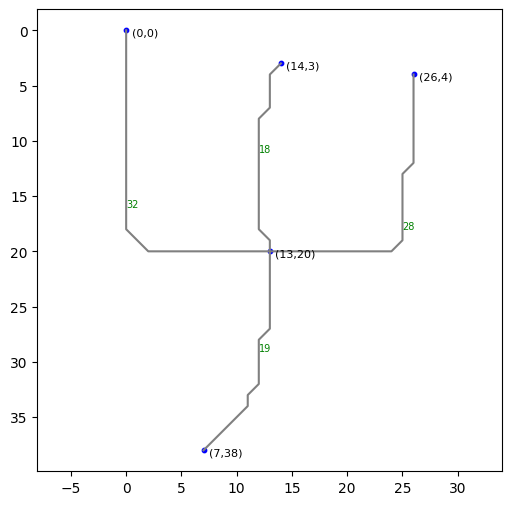

In [30]:
def draw_graph_with_lengths(G):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    # Отрисовка рёбер с сохранением формы
    for u, v, data in G.edges(data=True):
        path = data.get("path", [u, v])
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        ax.plot(xs, ys, color='gray')

        # Получение длины из данных ребра (по ключу length или weight)
        length = data.get("length", data.get("weight", None))

        if length is not None:
            mid_idx = len(path) // 2
            mid_point = path[mid_idx]
            ax.text(mid_point[0], mid_point[1], f"{length:.0f}", fontsize=7, color='green')

    # Отрисовка узлов
    nodes = list(G.nodes())
    node_x = [n[0] for n in nodes]
    node_y = [n[1] for n in nodes]
    ax.scatter(node_x, node_y, color='blue', s=10)

    # Отметка номеров вершин
    for n in nodes:
        ax.text(n[0] + 0.5, n[1] + 0.5, f"({int(n[0])},{int(n[1])})", fontsize=8)

    ax.invert_yaxis()
    plt.axis("equal")
    plt.show()

draw_graph_with_lengths(aggregated)

### Удаление засечек

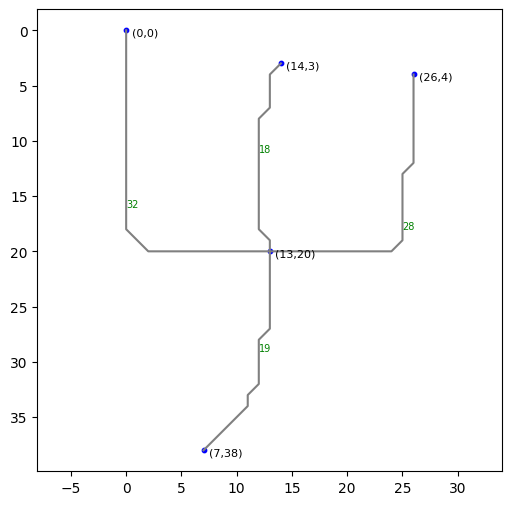

In [33]:
def remove_serif(graph, width, height):
    xs = [x for x, y in graph.nodes()]
    ys = [y for x, y in graph.nodes()]
    B_W = width 
    B_H = height
    
    threshold = (2 / 7) * max(B_H, B_W)
    nodes_to_remove = []

    for node in list(graph.nodes()):
        if graph.degree(node) == 1:
            neighbors = list(graph[node])
            if not neighbors:
                continue
            neighbor = neighbors[0]
            for key, data in graph[node][neighbor].items():
                length = data.get("length", data.get("weight", None))
                if length is not None and length <= threshold:
                    nodes_to_remove.append(node)
                    break
    
    graph.remove_nodes_from(nodes_to_remove)
    return graph

without_serif = remove_serif(aggregated, width, height)
draw_graph_with_lengths(without_serif)

### Повторная агрегация

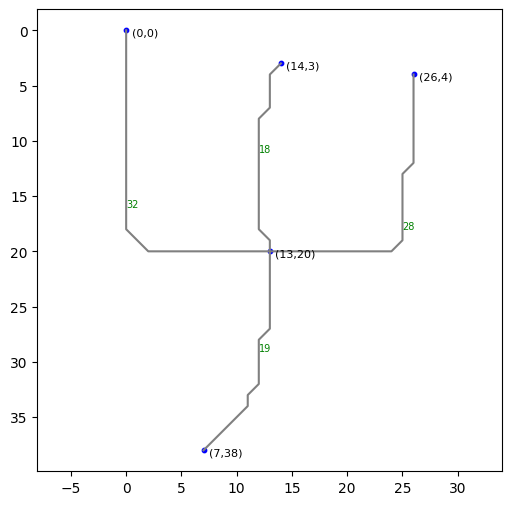

In [34]:
def unroll_aggregated_graph(aggregated_graph):
    unrolled = nx.Graph()

    for u, v, data in aggregated_graph.edges(data=True):
        path = data.get('path')
        if path is None:
            continue

        for i in range(len(path) - 1):
            unrolled.add_edge(path[i], path[i + 1])

    return unrolled
    
g_unrolled = unroll_aggregated_graph(without_serif)
re_aggregated = aggregate_skeleton_graph(g_unrolled)
draw_graph_with_lengths(re_aggregated)

## Генерация признаков

### Верхний уровень

In [35]:
def get_graph_bounding_box(graph):
    x_coords = []
    y_coords = []

    for node in graph.nodes():
        x, y = node
        x_coords.append(x)
        y_coords.append(y)

    for _, _, data in graph.edges(data=True):
        if "points" in data:
            for x, y in data["points"]:
                x_coords.append(x)
                y_coords.append(y)

    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)

    return min_x, max_x, min_y, max_y

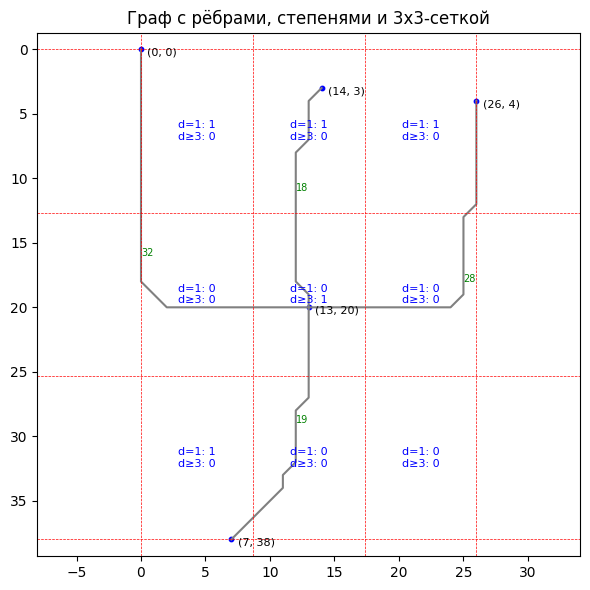

In [40]:
def generate_top_level_features(graph, min_x, max_x, min_y, max_y):
    pos = {node: node for node in graph.nodes()}

    x_bins = np.linspace(min_x, max_x, 4)  # 3 интервала => 4 границы
    y_bins = np.linspace(min_y, max_y, 4)

    counts = {(i, j): [0, 0] for i in range(3) for j in range(3)}
    node_bins = {(i, j): [] for i in range(3) for j in range(3)}

    for node in graph.nodes():
        x, y = node
        deg = graph.degree(node)
        col = np.digitize(x, x_bins) - 1
        row = np.digitize(y, y_bins) - 1

        row = min(row, 2)
        col = min(col, 2)

        if deg == 1:
            counts[(row, col)][0] += 1
            node_bins[(row, col)].insert(0, node)
        elif deg >= 3:
            counts[(row, col)][1] += 1
            node_bins[(row, col)].append(node)

    return counts, node_bins

min_x, max_x, min_y, max_y = get_graph_bounding_box(g_unrolled)
counts, node_bins = generate_top_level_features(re_aggregated, min_x, max_x, min_y, max_y)

plt.figure(figsize=(6, 6))
ax = plt.gca()

x_bins = np.linspace(min_x, max_x, 4)
y_bins = np.linspace(min_y, max_y, 4)


for u, v, data in re_aggregated.edges(data=True):
    path = data.get("path", [u, v])
    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    ax.plot(xs, ys, color='gray')

    length = data.get("length", data.get("weight", None))

    if length is not None:
        mid_idx = len(path) // 2
        mid_point = path[mid_idx]
        ax.text(mid_point[0], mid_point[1], f"{length:.0f}", fontsize=7, color='green')

node_x = [n[0] for n in re_aggregated.nodes()]
node_y = [n[1] for n in re_aggregated.nodes()]
ax.scatter(node_x, node_y, color='blue', s=10)

for n in re_aggregated.nodes():
    ax.text(int(n[0]) + 0.5, int(n[1]) + 0.5, f"({int(n[0])}, {int(n[1])})", fontsize=8)

for x in x_bins:
    ax.axvline(x, color='red', linestyle='--', linewidth=0.5)
for y in y_bins:
    ax.axhline(y, color='red', linestyle='--', linewidth=0.5)

for (row, col), stat in counts.items():
    center_x = (x_bins[col] + x_bins[col+1]) / 2
    center_y = (y_bins[row] + y_bins[row+1]) / 2
    label = f"d=1: {stat[0]}\nd≥3: {stat[1]}"
    ax.text(center_x, center_y, label, ha='center', va='center', fontsize=8, color='blue')

ax.invert_yaxis()

plt.title("Граф с рёбрами, степенями и 3x3-сеткой")
plt.axis("equal")
plt.tight_layout()
plt.show()

### Нижний уровень

In [41]:
def euclidean(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def split_edge_preserving_geometry(path, mask):
    """Разбивает путь по маске, возвращая точки c_i, лежащие на изогнутом ребре"""
    if len(path) < 2:
        return [], []

    total_length = sum(euclidean(path[i], path[i+1]) for i in range(len(path) - 1))
    target_distances = [z * total_length for z in mask]

    split_points = []
    segment_lengths = []
    cumulative_length = 0.0
    target_idx = 0

    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        seg_len = euclidean(p1, p2)

        while (target_idx < len(target_distances) and
               cumulative_length + seg_len >= target_distances[target_idx]):

            remaining = target_distances[target_idx] - cumulative_length
            alpha = remaining / seg_len
            x = p1[0] + alpha * (p2[0] - p1[0])
            y = p1[1] + alpha * (p2[1] - p1[1])
            split_points.append((round(x, 6), round(y, 6)))

            segment_lengths.append(round(remaining, 6))
            seg_len -= remaining
            p1 = (x, y)
            cumulative_length = target_distances[target_idx]
            target_idx += 1

        cumulative_length += seg_len

    if split_points:
        last_pt = split_points[-1]
        last_len = round(total_length - sum(segment_lengths), 6)
        segment_lengths.append(last_len)

    return split_points

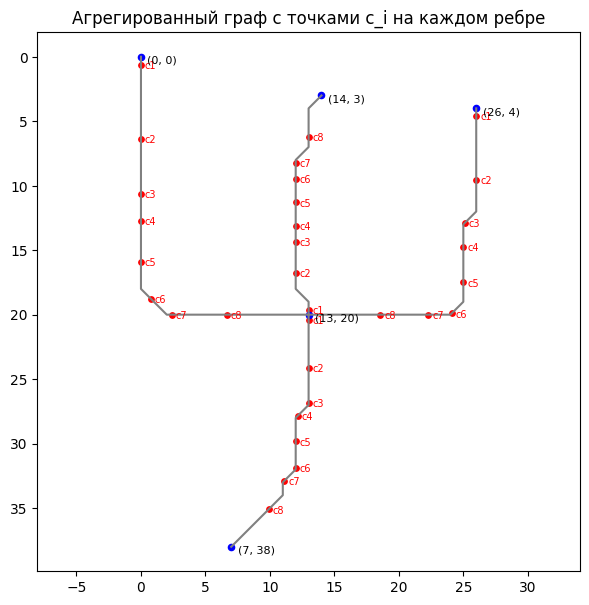

In [44]:
split_mask = [1/50, 1/5, 1/3, 2/5, 1/2, 3/5, 2/3, 4/5]

plt.figure(figsize=(7, 7))
ax = plt.gca()

for u, v, data in re_aggregated.edges(data=True):
    path = data.get("path", [u, v])

    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    ax.plot(xs, ys, color='gray')

    c_points = split_edge_preserving_geometry(path, split_mask)

    for i, pt in enumerate(c_points):
        ax.scatter(pt[0], pt[1], color='red', s=15)
        ax.text(pt[0] + 0.3, pt[1] + 0.3, f'c{i+1}', fontsize=7, color='red')

nodes = list(re_aggregated.nodes())
node_x = [n[0] for n in nodes]
node_y = [n[1] for n in nodes]
ax.scatter(node_x, node_y, color='blue', s=20)

for n in nodes:
    ax.text(int(n[0]) + 0.5, int(n[1]) + 0.5, f"({int(n[0])}, {int(n[1])})", fontsize=8)

ax.invert_yaxis()

plt.title("Агрегированный граф с точками c_i на каждом ребре")
plt.axis("equal")
plt.show()

In [46]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else np.zeros_like(v)

def compute_unit_vectors(A, c_points):
    """Признак 1: нормализованные вектора (A -> C_i)"""
    return [list(np.round(normalize_vector(np.array(c) - np.array(A)), 2)) for c in c_points]

def compute_angles_with_horizontal(A, c_points):
    """Признак 2: углы между (1, 0) и (A -> C_i) в градусах"""
    ref = np.array([1.0, 0.0])
    angles = []
    for c in c_points:
        vec = np.array(c) - np.array(A)
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(ref[1], ref[0])
        angle = (angle + np.pi) % (2 * np.pi) - np.pi
        angles.append(round(np.degrees(angle), 2))
    return angles

def compute_internal_angles(c_points):
    """Признак 3: углы между векторами (C_{i-1}->C_i) и (C_i->C_{i+1}) в градусах"""
    angles = []
    for i in range(1, len(c_points) - 1):
        v1 = np.array(c_points[i]) - np.array(c_points[i - 1])
        v2 = np.array(c_points[i + 1]) - np.array(c_points[i])
        angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        angle = (angle + np.pi) % (2 * np.pi) - np.pi
        angles.append(round(np.degrees(angle), 2))
    return angles

def compute_length_ratios(A, c_points):
    """Признак 4: отношения длин ||AC_i|| / ||AC_{i-1}||"""
    m_values = [np.linalg.norm(np.array(c) - np.array(A)) for c in c_points]
    ratios = [
        round(m_values[i] / m_values[i - 1], 2) if m_values[i - 1] != 0 else 0.0
        for i in range(1, len(m_values))
    ]
    return ratios

### Создание датасета

In [47]:
split_mask = [1/50, 1/5, 1/3, 2/5, 1/2, 3/5, 2/3, 4/5]

columns = ["id", (0, 0), (0, 1), (0, 2),
           (1, 0), (1, 1), (1, 2),
           (2, 0), (2, 1), (2, 2)]
columns_str = [str(col) for col in columns]

top_level_features = pd.DataFrame(columns=columns_str)

low_level_features = pd.DataFrame(columns=[
    "letter_number_in_dataset",
    "top_level_feature_id",
    "bin_coord",
    "unit_vectors",
    "angles_to_horizontal",
    "internal_angles",
    "length_ratios",
    "letter_id"
])

In [32]:
folder_path = 'letters2'
i = 0

for letter_id in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, letter_id)
    #print(letter_id)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.JPG')):
                image_bgr = cv2.imread(os.path.join(subfolder_path, filename))
                if image_bgr is None:
                    print(f"Ошибка загрузки изображения: {image_path}")
                    continue

                image = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2GRAY)
                i = i + 1
                graph, height, width = get_skeleton_graph(image)
                aggregated = aggregate_skeleton_graph(graph)
                without_serif = remove_serif(aggregated, width, height)
                g_unrolled = unroll_aggregated_graph(without_serif)
                re_aggregated = aggregate_skeleton_graph(g_unrolled)
                min_x, max_x, min_y, max_y = get_graph_bounding_box(g_unrolled)
                counts, node_bins = generate_top_level_features(re_aggregated, min_x, max_x, min_y, max_y)
#верхний уровень
                comparison_columns = [col for col in top_level_features.columns if col != "id"]
                row = {str(k): v for k, v in counts.items()}
                row_df = pd.DataFrame([row])
                mask = (top_level_features[comparison_columns] == row_df[comparison_columns].iloc[0]).all(axis=1)
                
                if not mask.any():
                    tlf_id = len(top_level_features)
                    row["id"] = tlf_id
                    top_level_features.loc[len(top_level_features)] = row
                else:
                    tlf_id = top_level_features.loc[mask, "id"].values[0]
                    
#нижний уровень
                for (row, col), nodes in node_bins.items():
                    features_unit_vectors = []
                    features_angles_to_horizontal = []
                    features_internal_angles = []
                    features_length_ratios = []
                    for node in nodes:
                        neighbors = re_aggregated.neighbors(node)
                        for nbr in neighbors:
                            # Получаем все рёбра между node и nbr
                            for key, data in re_aggregated.get_edge_data(node, nbr).items():
                                path = data.get("path", [node, nbr])
                                
                                # Получаем точки c_i вдоль пути
                                c_points = split_edge_preserving_geometry(path, split_mask)
                                features_unit_vectors.append(compute_unit_vectors(node, c_points))
                                features_angles_to_horizontal.append(compute_angles_with_horizontal(node, c_points))
                                features_internal_angles.append(compute_internal_angles([node] + c_points + [nbr]))
                                features_length_ratios.append(compute_length_ratios(node, c_points + [nbr]))
                
                    if features_unit_vectors:
                        low_level_features.loc[len(low_level_features)] = {
                            "letter_number_in_dataset": i,
                            "top_level_feature_id": tlf_id,
                            "bin_coord": (row, col),
                            "unit_vectors": features_unit_vectors,
                            "angles_to_horizontal": features_angles_to_horizontal,
                            "internal_angles": features_internal_angles,
                            "length_ratios": features_length_ratios,
                            "letter_id": letter_id
                        }

In [139]:
low_level_features.to_excel("llf.xlsx")

In [140]:
top_level_features.to_excel("tlf.xlsx")

### Поиск символа

In [24]:
low_level_features = pd.read_excel('llf.xlsx')
top_level_features = pd.read_excel("tlf.xlsx")
top_level_features.columns = top_level_features.columns.map(str)

# Преобразуем все значения, кроме id, обратно в списки
for col in top_level_features.columns:
    if col != "id":
        top_level_features[col] = top_level_features[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
        )

In [71]:
def normalize_full(lst):
    return sorted([sorted(sub) for sub in lst])

def flatten(lst):
    return np.array([x for sub in lst for x in sub])

def distance(a, b):
    fa = flatten(normalize_full(a))
    fb = flatten(normalize_full(b))
    if len(fa) != len(fb):
        return np.inf
    return np.linalg.norm(fa - fb)

def predict_letter_number(image):
    llf_grapheme = pd.DataFrame(columns=[
        "bin_coord",
        "unit_vectors",
        "angles_to_horizontal",
        "internal_angles",
        "length_ratios"
    ])
    graph, height, width = get_skeleton_graph(image)
    aggregated = aggregate_skeleton_graph(graph)
    without_serif = remove_serif(aggregated, width, height)
    g_unrolled = unroll_aggregated_graph(without_serif)
    re_aggregated = aggregate_skeleton_graph(g_unrolled)
    min_x, max_x, min_y, max_y = get_graph_bounding_box(g_unrolled)
    counts, node_bins = generate_top_level_features(re_aggregated, min_x, max_x, min_y, max_y)

    comparison_columns = [col for col in top_level_features.columns if col != "id"]
    row = {str(k): v for k, v in counts.items()}
    row_df = pd.DataFrame([row])
    mask = (top_level_features[comparison_columns] == row_df[comparison_columns].iloc[0]).all(axis=1)
    
    if not mask.any():
        return 0

    tlf_id = top_level_features.loc[mask, "id"].values[0]

    if len(low_level_features[low_level_features['top_level_feature_id'] == tlf_id]['letter_id'].unique()) == 1:
        return low_level_features[low_level_features['top_level_feature_id'] == tlf_id]['letter_id'].iloc[0]

    if len(low_level_features[low_level_features['top_level_feature_id'] == tlf_id]['letter_id'].unique()) == 0:
        return -1
        
    for (row, col), nodes in node_bins.items():
        features_unit_vectors = []
        features_angles_to_horizontal = []
        features_internal_angles = []
        features_length_ratios = []
        for node in nodes:
            neighbors = re_aggregated.neighbors(node)
            for nbr in neighbors:
                for key, data in re_aggregated.get_edge_data(node, nbr).items():
                    path = data.get("path", [node, nbr])
                    c_points = split_edge_preserving_geometry(path, split_mask)
                    features_unit_vectors.append(compute_unit_vectors(node, c_points))
                    features_angles_to_horizontal.append(compute_angles_with_horizontal(node, c_points))
                    features_internal_angles.append(compute_internal_angles([node] + c_points + [nbr]))
                    features_length_ratios.append(compute_length_ratios(node, c_points + [nbr]))
    
        if features_unit_vectors:
            llf_grapheme.loc[len(llf_grapheme)] = {
                "bin_coord": (row, col),
                "unit_vectors": features_unit_vectors,
                "angles_to_horizontal": features_angles_to_horizontal,
                "internal_angles": features_internal_angles,
                "length_ratios": features_length_ratios,
            }

    distances = dict.fromkeys(low_level_features[low_level_features['top_level_feature_id'] == tlf_id]['letter_number_in_dataset'].unique(), 0)
    feature_names = ['unit_vectors', 'angles_to_horizontal', 'internal_angles', 'length_ratios']
    for letter_in_dataset in low_level_features[low_level_features['top_level_feature_id'] == tlf_id]['letter_number_in_dataset'].unique():
        llf_letter_in_dataset = low_level_features[(low_level_features['top_level_feature_id'] == tlf_id) & (low_level_features['letter_number_in_dataset'] == letter_in_dataset)]

        for current_bin_coord in llf_grapheme['bin_coord'].unique():
            for feature in feature_names:
                value_in_dataset = llf_letter_in_dataset[llf_letter_in_dataset['bin_coord'] == current_bin_coord][feature].values[0]
                search_value = llf_grapheme[llf_grapheme['bin_coord'] == current_bin_coord][feature].values[0]
                distances[letter_in_dataset] += distance(value_in_dataset, search_value)

    return low_level_features[(low_level_features['top_level_feature_id'] == tlf_id) & (low_level_features['letter_number_in_dataset'] == min(distances, key=distances.get))]['letter_id'].values[0]

### Предсказание на тестовом датасете

In [84]:
folder_path = 'letters/test_dataset'
i = 0
j = 0
for letter_id in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, letter_id)
    #print(letter_id)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.JPG')):
                image_bgr = cv2.imread(os.path.join(subfolder_path, filename))
                if image_bgr is None:
                    print(f"Ошибка загрузки изображения: {image_path}")
                    continue

                image = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2GRAY)
                print(letter_id, predict_letter_number(image))
                if letter_id == predict_letter_number(image):
                    i += 1
                if predict_letter_number(image) == -1:
                    print(os.path.join(subfolder_path, filename))
                j += 1

1 1
1 1
1 1
1 1
1 0
1 1
10 23
10 10
10 10
10 10
10 10
10 10
11 11
11 11
11 11
11 18
11 0
11 11
15 30
15 0
15 15
15 15
16 8
16 16
16 16
16 16
16 0
16 16
17 17
17 17
17 17
17 17
17 17
17 17
18 18
18 18
18 18
18 18
18 18
18 11
2 2
2 2
2 2
2 2
2 2
2 2
20 16
20 20
20 20
20 20
20 20
20 16
21 21
21 21
21 21
21 21
21 21
21 21
22 22
22 22
22 22
22 22
22 22
22 10
23 20
23 23
23 23
23 23
23 23
23 23
24 24
24 24
24 30
24 24
24 24
24 24
27 27
27 27
27 27
27 27
27 4
27 27
28 28
28 28
28 28
28 28
28 28
28 28
29 29
29 29
29 29
29 29
29 29
29 29
3 3
3 3
3 3
3 3
3 3
3 3
30 24
30 30
30 30
30 30
30 30
30 30
31 31
31 31
31 31
31 31
31 0
31 31
32 32
32 32
32 32
32 32
32 0
32 32
33 33
33 33
33 33
33 33
33 33
33 36
34 34
34 0
34 0
34 34
34 34
34 0
35 35
35 35
35 35
35 35
35 33
35 0
36 0
36 36
36 0
36 36
36 36
36 2
37 0
37 37
37 37
38 0
38 38
38 38
38 38
38 38
38 38
39 39
39 39
39 0
39 0
39 39
39 39
4 23
4 23
4 4
4 0
4 23
41 41
41 41
41 0
41 41
41 41
41 41
5 5
5 0
5 0
5 1
5 5
5 5
7 7
7 7
7 7
7 7
7 7
7 7
8 8
8 